In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [45]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

In [46]:
from medvqa.utils.files import load_pickle
import numpy as np
import medvqa
import os
from importlib import reload
from medvqa.evaluation.plots import visualize_predicted_bounding_boxes__yolo, plot_metrics
from medvqa.datasets.vinbig import VINBIG_BBOX_NAMES__MODIFIED, VINBIG_BBOX_NAMES__MODIFIED
from medvqa.metrics.bbox.utils import compute_mAP__yolov11
from medvqa.utils.logging import print_magenta

In [3]:
# source: https://www.kaggle.com/competitions/vinbigdata-chest-xray-abnormalities-detection/data
VINBIGDATA_CHALLENGE_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
]
assert all(x in VINBIG_BBOX_NAMES__MODIFIED for x in VINBIGDATA_CHALLENGE_CLASSES)

# source: https://github.com/philip-mueller/chex/blob/main/conf/dataset/class_names/vindrcxr_loc_top15.yaml
CHEX_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Cardiomegaly',
    'Calcification',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Mediastinal shift',
    'Nodule/Mass',
    'Pulmonary fibrosis',
    'Pneumothorax',
    'Pleural thickening',
    'Pleural effusion',
    'Other lesion',
]
assert all(x in VINBIG_BBOX_NAMES__MODIFIED for x in CHEX_CLASSES)

ALL_VINBIG_CLASSES = VINBIG_BBOX_NAMES__MODIFIED + ['COPD', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other disease']

CHEX_IOU_THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [7]:
def compute_map_metrics_from_results(results_path, iou_thresholds = [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    results = load_pickle(results_path)
    res = compute_mAP__yolov11(
        gt_coords=results['gt_bboxes'],
        pred_boxes=results['pred_boxes_list'],
        pred_classes=results['pred_classes_list'],
        pred_confs=results['pred_confs_list'],
        iou_thresholds=iou_thresholds,
        compute_micro_average=True,
    )
    class_aps = res['class_aps']
    micro_aps = res['micro_aps']
        
    for iou_thresh, map_ in zip(iou_thresholds, class_aps.mean(axis=1)):
        print_magenta(f'mAP@{iou_thresh}: {map_}', bold=True)

    for iou_thresh, ap in zip(iou_thresholds, micro_aps):
        print_magenta(f'micro_AP@{iou_thresh}: {ap}', bold=True)
        
    # vinbigdata metric
    class_idxs = [VINBIG_BBOX_NAMES__MODIFIED.index(x) for x in VINBIGDATA_CHALLENGE_CLASSES]
    iou_idx = iou_thresholds.index(0.4)
    mAP = class_aps[iou_idx, class_idxs].mean()
    print_magenta(f'vinbigdata mAP@0.4: {mAP}', bold=True)

    # ChEX metric
    class_idxs = [VINBIG_BBOX_NAMES__MODIFIED.index(x) for x in CHEX_CLASSES]
    iou_idxs = [iou_thresholds.index(x) for x in CHEX_IOU_THRESHOLDS]
    mAP = class_aps[iou_idxs][:, class_idxs].mean()
    print_magenta(f'ChEX mAP@{CHEX_IOU_THRESHOLDS}: {mAP}', bold=True)

In [8]:
def detection_score(i, tmp, verbose=False):

    from medvqa.metrics.bbox.utils import calculate_exact_iou_union

    gt_bbox_coords = tmp['gt_bboxes'][i]

    num_gt_bboxes = 0
    for bboxes in gt_bbox_coords:
        num_gt_bboxes += len(bboxes)
    
    if num_gt_bboxes == 0:
        return 0

    pred_coords = tmp['pred_boxes_list'][i]
    pred_classes = tmp['pred_classes_list'][i]
    pred_confs = tmp['pred_confs_list'][i]

    nc = len(gt_bbox_coords)

    absent_acc_prob = 0
    absent_count = 0
    present_acc_iou = 0
    present_count = 0

    for c in range(nc):
        c_idxs = [i for i, x in enumerate(pred_classes) if x == c]
        gt_bboxes = gt_bbox_coords[c]

        if len(gt_bboxes) == 0: # absent
            if len(c_idxs) == 0:
                absent_acc_prob += 0
            else:
                absent_acc_prob += pred_confs[c_idxs].max()
            absent_count += 1
        else: # present
            present_acc_iou += calculate_exact_iou_union(gt_bboxes, pred_coords[c_idxs])
            present_count += 1

    assert absent_count > 0
    assert present_count > 0

    iou_score = present_acc_iou / present_count
    prob_score = absent_acc_prob / absent_count
    prob_score = 1 - prob_score
    if verbose:
        print(f'iou_score: {iou_score}, prob_score: {prob_score}')
    return iou_score + prob_score    

# YOLOv11 (trained on VinDrCXR with modified labels)

In [25]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20250216_173251_vinbig_yolo11l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_conf_thresholds 0.01 0.025 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_iou_thresholds 0.01 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--max_det 200 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20250216_173251_vinbig_yolo11l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   vinbig_use_training_indices_for_validation: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   max_det: 200
   use_amp: True
Activating determinism(seed=42)...
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20250216_173251_vinbig_yolo11l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder:

conf_th=0.05, iou_th=0.02, mAP=0.21132961420359694 (time_input_processing=1.7636377811431885, time_map=2.9758412837982178)
conf_th=0.05, iou_th=0.05, mAP=0.21091172714187997 (time_input_processing=1.8068294525146484, time_map=3.0359013080596924)
conf_th=0.05, iou_th=0.1, mAP=0.20774443086157945 (time_input_processing=1.8108270168304443, time_map=3.0888028144836426)
conf_th=0.05, iou_th=0.2, mAP=0.2039601184838345 (time_input_processing=1.8287014961242676, time_map=3.5592403411865234)
conf_th=0.05, iou_th=0.3, mAP=0.1981836038865725 (time_input_processing=1.8776755332946777, time_map=3.3936192989349365)
conf_th=0.05, iou_th=0.4, mAP=0.19388642687731752 (time_input_processing=1.8611152172088623, time_map=3.5828380584716797)
conf_th=0.05, iou_th=0.5, mAP=0.18592109067296836 (time_input_processing=1.7365972995758057, time_map=3.476358652114868)
conf_th=0.1, iou_th=0.01, mAP=0.1987321510347737 (time_input_processing=1.2770657539367676, time_map=2.0726332664489746)
conf_th=0.1, iou_th=0.02, 

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250216_173251_vinbig_yolo11l(d:vinbig)/vindrcxr_metrics(detection,3000,opt_thr(0.01,0.03,200)).pkl


In [3]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250216_173251_vinbig_yolo11l(d:vinbig)/vindrcxr_metrics(detection,3000,opt_thr(0.01,0.03,200)).pkl')

In [4]:
tmp.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'gt_bboxes', 'sample_ious', 'map_iou_thresholds', 'metrics_without_bootstrapping', 'metrics_with_bootstrapping', 'best_iou_threshold', 'best_conf_threshold', 'max_det'])

In [9]:
scores = [detection_score(i, tmp) for i in range(len(tmp['gt_bboxes']))]
idxs = np.argsort(scores)[::-1]

In [11]:
bbox_names = VINBIG_BBOX_NAMES__MODIFIED[:]
bbox_names.remove('Edema')
bbox_names

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Clavicle fracture',
 'Consolidation',
 'Emphysema',
 'Enlarged PA',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Lung cavity',
 'Lung cyst',
 'Mediastinal shift',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'Rib fracture',
 'Abnormal finding']

In [12]:
classes_to_highlight = bbox_names[:]
classes_to_highlight.remove('Abnormal finding')
# classes_to_highlight = ['Abnormal finding']

iou_score: 0.7136364524561386, prob_score: 0.9906929417660362
0.71363646
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/3c22b17493566a9bca5ac33f0cd0b42f.jpg


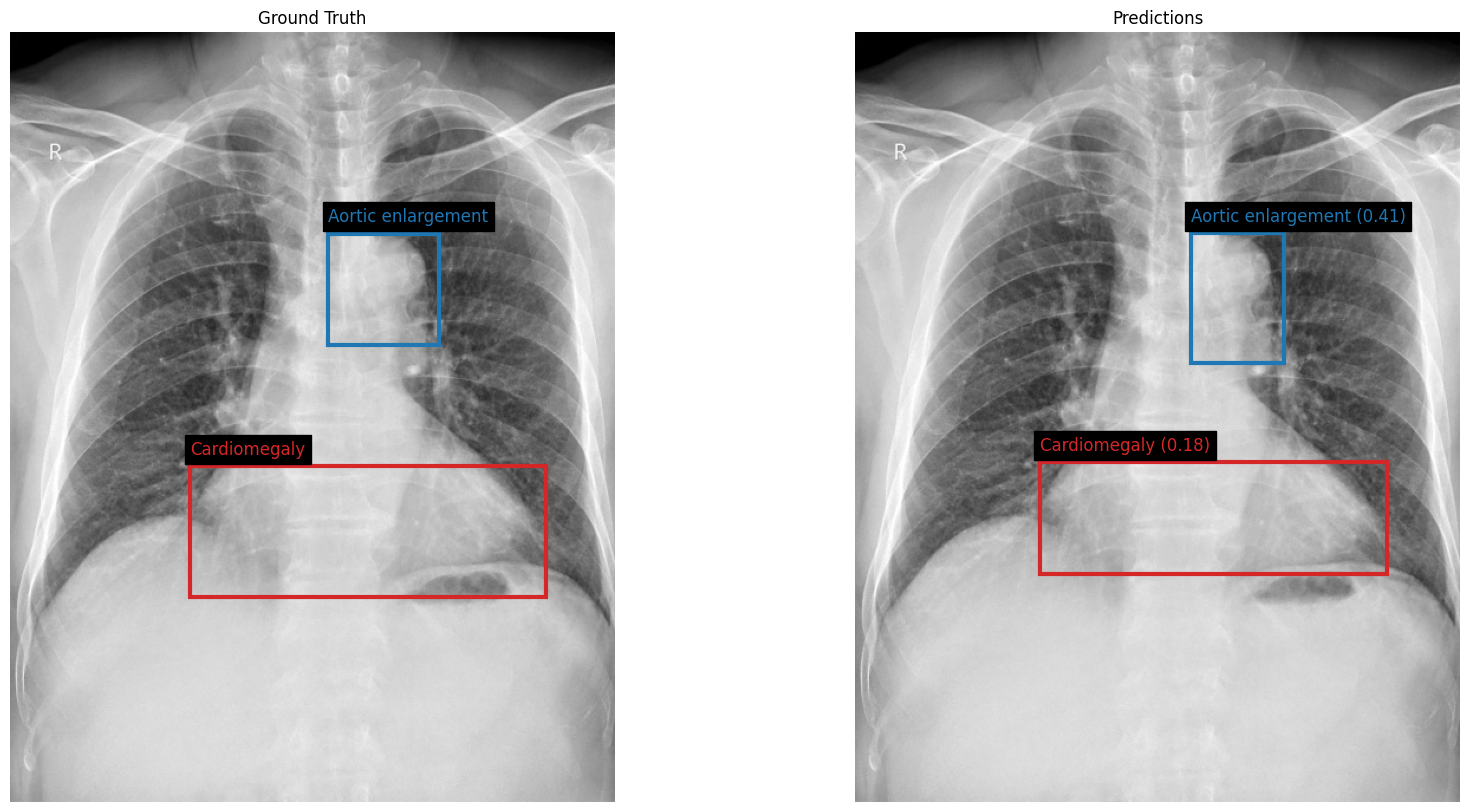

In [47]:
i = 200
i = idxs[i]
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/85718436181b19f2d96683adba71e0fb.jpg')
i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/3c22b17493566a9bca5ac33f0cd0b42f.jpg')
detection_score(i, tmp, verbose=True)
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=bbox_names,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=classes_to_highlight,
    hide_other_classes=True,
    minimum_confidence=0.1,
)

iou_score: 0.47042731354992284, prob_score: 0.9776009952320772
0.47042733
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/1e4029a54dd47b7223885e14cc0e020f.jpg


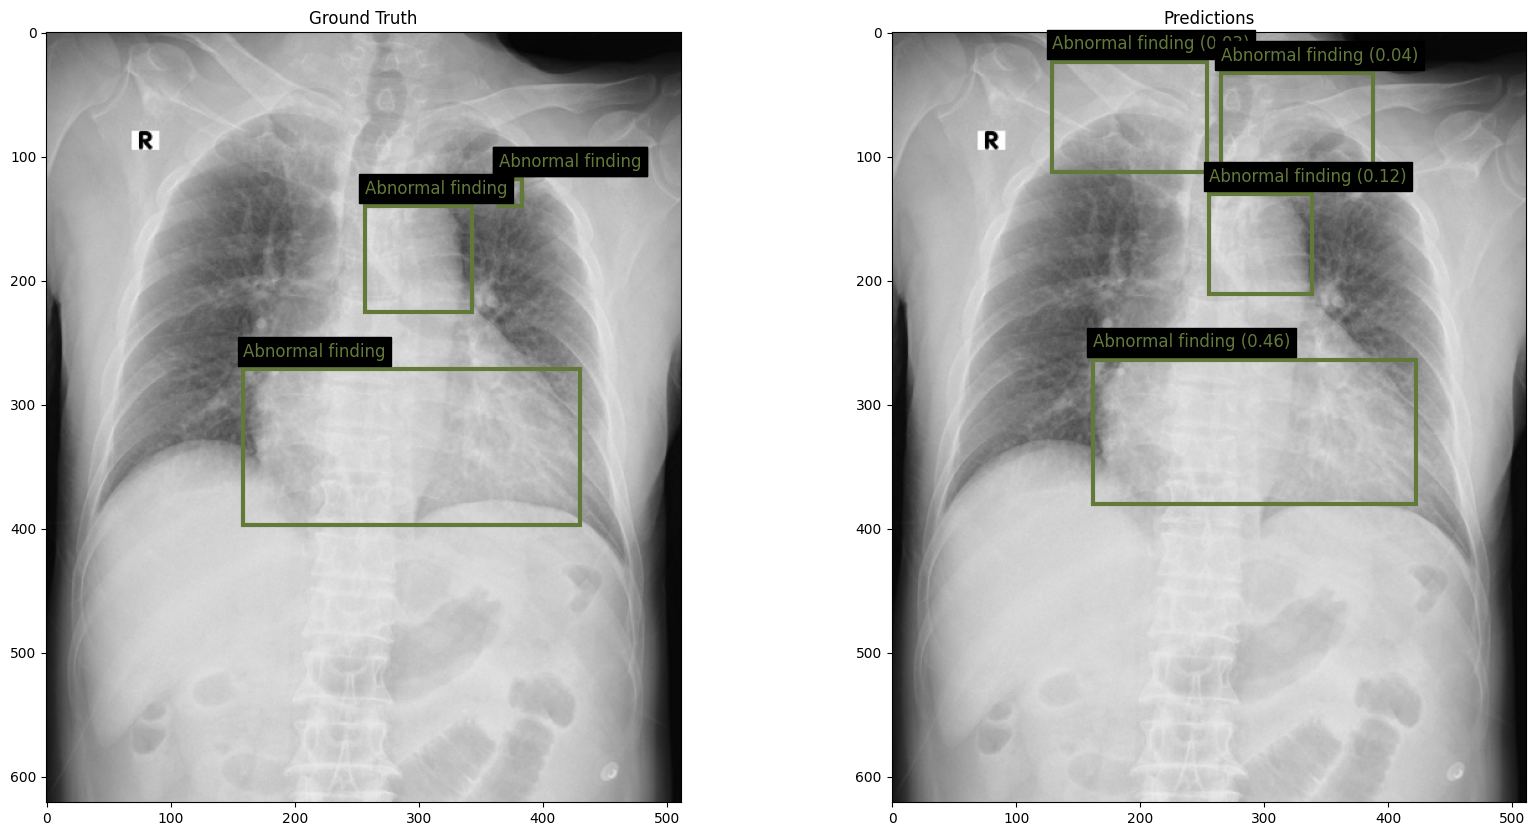

In [40]:
# i = 40
i = 200
i = idxs[i]
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/85718436181b19f2d96683adba71e0fb.jpg')
detection_score(i, tmp, verbose=True)
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=bbox_names,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=['Abnormal finding'],
    hide_other_classes=True,
#     minimum_confidence=0.1,
)

In [14]:
from medvqa.datasets.vinbig import compute_label_frequencies

label_frequencies = compute_label_frequencies()

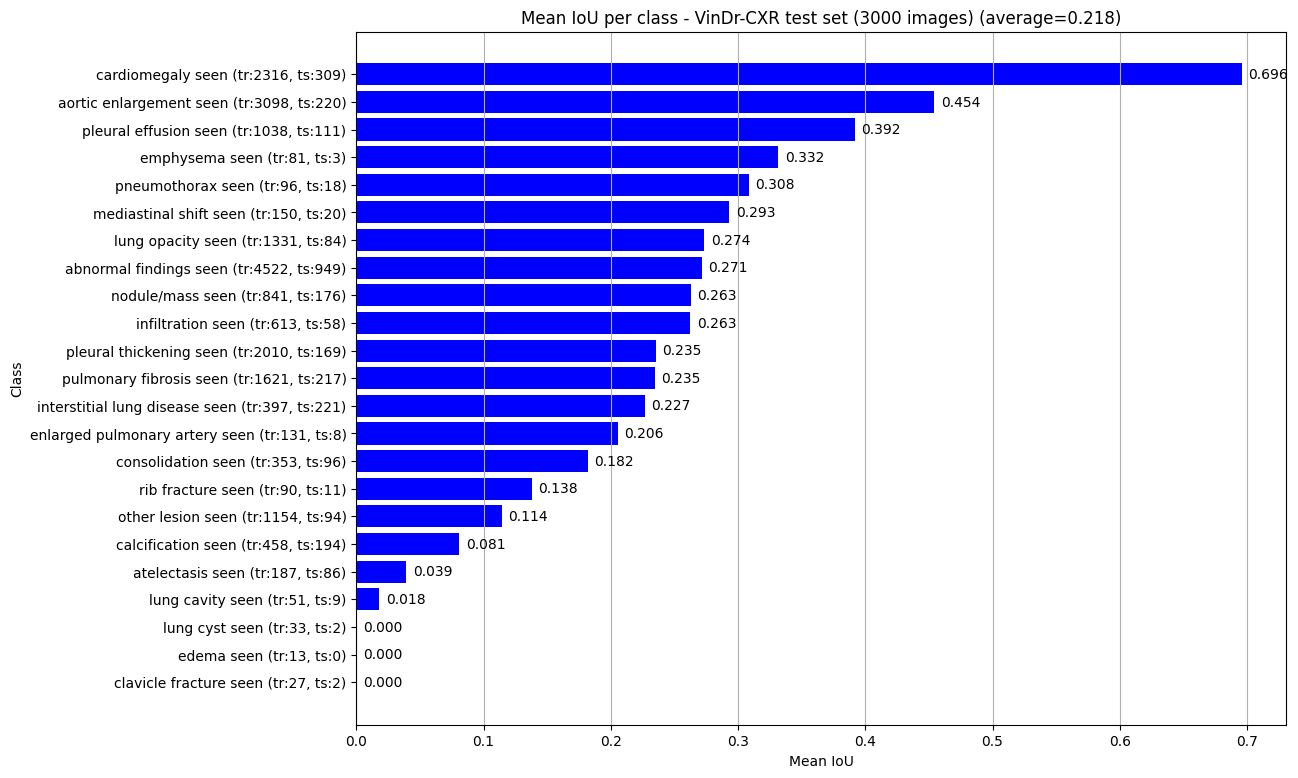

In [16]:
from medvqa.utils.constants import VINBIG_LABEL2PHRASE

metric_names = []
for x in VINBIG_BBOX_NAMES__MODIFIED:
    if x == 'Abnormal finding':
        tr = 15000 - label_frequencies["train"]['No finding']
        ts = 3000 - label_frequencies["test"]['No finding']
    else:
        tr = label_frequencies["train"][x]
        ts = label_frequencies["test"][x]
    metric_names.append(f'{VINBIG_LABEL2PHRASE[x]} (tr:{tr}, ts:{ts})')

plot_metrics(
    metric_names=metric_names,
    metric_values=tmp['class_ious'],
    title='Mean IoU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IoU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)